In [25]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import olympus
from olympus.scalarizers import Scalarizer
from olympus.datasets import Dataset

In [26]:
# load resulsts
res_rand = pickle.load(open('../results/results_random.pkl', 'rb'))
res_bo   = pickle.load(open('../results/results_botorch.pkl', 'rb'))

print(len(res_rand))
print(len(res_bo))


dataset = Dataset('lnp')

scalarizer = Scalarizer(
        kind='Hypervolume',
        value_space=dataset.value_space,
        goals=['min', 'max'],
    )


def unpack_results(res):
    
    num_iter = res[0].shape[0]
    new_dfs = []
    
    for ix in range(len(res)):
        r = deepcopy(res[ix])
        scal = scalarizer.scalarize(r.loc[:, ['particle_diameter', 'drug_loading']].values)
        trace_best_ix = [np.argmin(scal[:i+1]) for i in range(len(scal))]
        trace0 = [r.loc[i, 'particle_diameter'] for i in trace_best_ix]
        trace1 = [r.loc[i, 'drug_loading'] for i in trace_best_ix]
        r['iter'] = np.arange(r.shape[0])+1
        r['repeat'] = ix
        r['best_particle_diameter'] = 10**np.array(trace0)
        r['best_drug_loading'] = trace1
        new_dfs.append(r)
        
    return pd.concat(new_dfs, ignore_index=True)
        
        
res_rand = unpack_results(res_rand)
res_bo = unpack_results(res_bo)

20
6


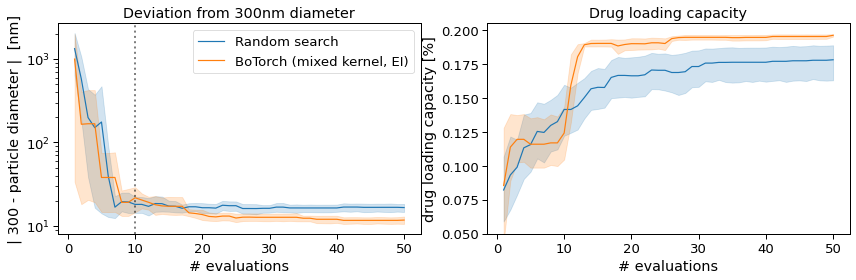

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=res_rand, x='iter', y='best_particle_diameter', ax=ax0, label='Random search')
sns.lineplot(data=res_rand, x='iter', y='best_drug_loading', ax=ax1)

sns.lineplot(data=res_bo, x='iter', y='best_particle_diameter', ax=ax0, label='BoTorch (mixed kernel, EI)')
sns.lineplot(data=res_bo, x='iter', y='best_drug_loading', ax=ax1)

# ax0.set_yscale('log')

ax0.set_title('Deviation from 300nm diameter')
ax1.set_title('Drug loading capacity')

# ax0.set_ylim(0.9, 2.6)
ax0.set_yscale('log')
ax1.set_ylim(0.05, 0.205)

ax0.set_xlabel('# evaluations')
ax1.set_xlabel('# evaluations')

ax0.set_ylabel('| 300 - particle diameter |  [nm]')
ax1.set_ylabel('drug loading capacity [%]')

ax0.axvline(10, lw=2, ls=':', alpha=0.5, c='k')

plt.tight_layout()
